### Import necessay packages

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
sns.set()
import warnings
warnings.filterwarnings('ignore')

### Loading and exploring data

In [2]:
df = pd.read_csv("data/oasis_longitudinal.csv")
df.head()

,ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [3]:
# Label encode categorical columns
to_drop = ['ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand']
if to_drop[0] in df.columns:
    df.drop(columns=to_drop, inplace=True)

# sex: 'F' == 0, 'M' == 1
# Group: 'Nondemented' == 0, 'Demented' or 'Converted' == 1
df.Group = df.Group.apply(lambda x: 0 if x == 'Nondemented' else 1)
df.Sex = df.Sex.apply(lambda x: 0 if x == 'F' else 1)

In [4]:
# Overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group   373 non-null    int64  
 1   Sex     373 non-null    int64  
 2   Age     373 non-null    int64  
 3   EDUC    373 non-null    int64  
 4   SES     354 non-null    float64
 5   MMSE    371 non-null    float64
 6   CDR     373 non-null    float64
 7   eTIV    373 non-null    int64  
 8   nWBV    373 non-null    float64
 9   ASF     373 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 29.3 KB


In [5]:
df.isnull().sum()

Group     0
Sex       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

In [6]:
df['SES'].value_counts()

2.0    103
1.0     88
3.0     82
4.0     74
5.0      7
Name: SES, dtype: int64

We will replace mising values by the most frequent value in both **SES** and **MMSE** columns.

In [7]:
df.MMSE.fillna(df.MMSE.value_counts().index[0], inplace=True)
df.SES.fillna(df.SES.value_counts().index[0], inplace=True)

### Few data visualizations

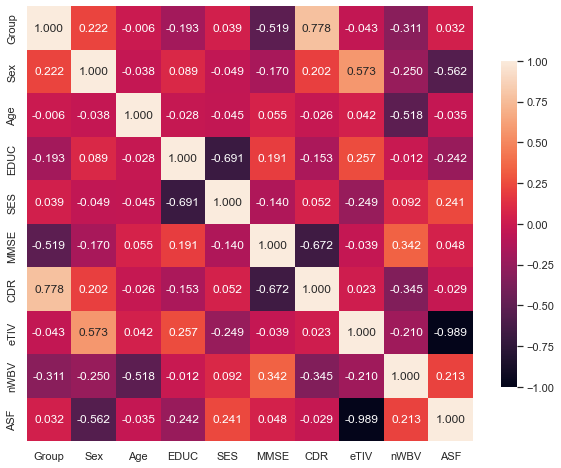

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cbar_kws={'shrink': .75}, fmt='.3f')
plt.show()

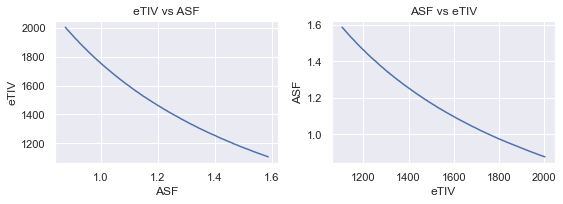

In [9]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].set_title('eTIV vs ASF')
ax[1].set_title('ASF vs eTIV')
sns.lineplot(x='ASF', y='eTIV', data=df, err_style=None, ax=ax[0])
sns.lineplot(y='ASF', x='eTIV', data=df, err_style=None, ax=ax[1])
plt.tight_layout()
plt.show()

In [10]:
def plot_scatter(x, y):
    title = f'{y} vs {x}'
    plt.figure(figsize=(6,4))
    sns.scatterplot(y=y, x=x, data=df, hue='Group')
    plt.title(title)
    plt.ylabel(y)
    plt.xlabel(x)
    plt.show()

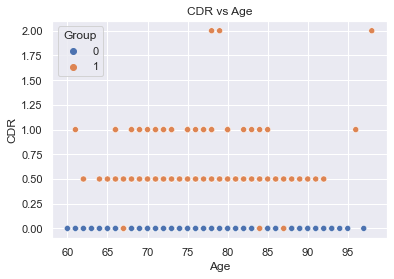

In [11]:
plot_scatter('Age', 'CDR')

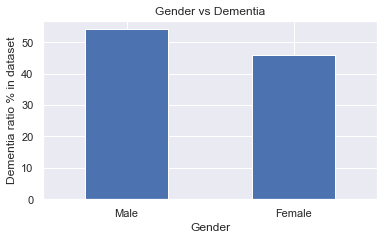

In [12]:
gender_df = pd.DataFrame(df[df.Group==1].Sex.value_counts() * 100/len(df[df.Group==1]))
gender_df.plot(kind='bar', figsize=(5.5,3.5), legend=None)
plt.title('Gender vs Dementia')
plt.xlabel('Gender')
plt.xticks([0,1],['Male', 'Female'],rotation=0)
plt.ylabel('Dementia ratio % in dataset')
plt.tight_layout()
plt.show()

### PRepare data for machine learning model training and evaluation

In [13]:

features = ['Sex','Age','EDUC','SES','MMSE','eTIV','nWBV','CDR']
X = df[features]
y = df.Group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


### Model training and evaluation

In [14]:
params_grid = {'n_estimators':[10, 15, 20],
         'max_features':['sqrt', 'auto'],
          'criterion':['gini'],
          'max_depth':[10, 15, 20],
          'oob_score':[True, False]
         }
rf_c = RandomForestClassifier(random_state=123)
grid_search = GridSearchCV(estimator=rf_c, param_grid=params_grid, scoring='accuracy', cv=6, refit=True, verbose=0)

grid_search.fit(X_train_scaled,y_train)

y_pred = grid_search.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)

# vals = grid_search.predict(X_val_scaled)
# val_acc = accuracy_score(y_val, vals)
print(f'Model Parameters: {grid_search.best_params_}')
print(f'Model training accuracy is {grid_search.best_score_ * 100:.2f}%')
print(f'Model Test accuracy: {test_acc*100:.2f}%')
# print(f'Model validation accuracy: {val_acc*100:.2f}')

Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20, 'oob_score': True}
Model training accuracy is 93.50%
Model Test accuracy: 95.54%


In [15]:
model = grid_search.best_estimator_

features = model.feature_importances_
feature_names = X_train.columns

print("Feature :\tImportance\n--------------------------")
for i in range(len(features)):
    print(f'{feature_names[i]}\t: \t {"%.5f" % features[i]}')

Feature :	Importance
--------------------------
Sex	: 	 0.02090
Age	: 	 0.05719
EDUC	: 	 0.05255
SES	: 	 0.02518
MMSE	: 	 0.17780
eTIV	: 	 0.09585
nWBV	: 	 0.10497
CDR	: 	 0.46555


### Evolution of the risk of contracting Alzheimer's disease with age

In [16]:
dfa = pd.read_csv("data/oasis_longitudinal.csv")
dfa = dfa.drop_duplicates('ID', keep='last', ignore_index=False)
df1 = dfa[dfa['Group']=='Demented'].sort_values(by='Age', ascending=True)
bin_lbls = ['60-64', '65-69', '70-74','75-79', '80-84', '85-89', '90-94', '95-98']
bins = [60, 65, 70, 75, 80, 85, 90, 95, 99]
df1['bins'] = pd.cut(df1['Age'], bins=bins, right=False, labels=bin_lbls)
Ages = df1['bins'].value_counts(sort=None)

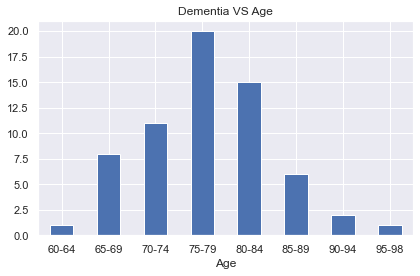

In [17]:
Ages.plot(kind='bar', figsize=(6,4), legend=None)
plt.title('Dementia VS Age')
plt.xlabel('Age')
plt.xticks([*range(8)],bin_lbls,rotation=0)
plt.tight_layout()
plt.show()